In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
macro = pd.read_csv("/kaggle/input/boost-data/macroeconomics.csv", index_col=0)
alex = pd.read_csv("/kaggle/input/boost-data/price_per_meter_2017_2024_v2.csv", index_col=0)
alex = pd.merge(macro, alex, on="Date", how="left")

In [3]:
alex = alex.drop(["Alexandria's Real Estate Ownership (GDP) (Thousands EGP)"], axis=1)

alex['Year'] = alex['Date'].str[:4]  
alex['Quarter'] = alex['Date'].str[5:].astype(int)

alex = alex.drop_duplicates(subset=["Date"]).reset_index(drop=True)

# drop 2024Q4 column
alex = alex[:-1]

og_columns = list(alex.columns)

# **Lags Selection Using Lasso**

In [4]:
# lags["Aqarmap Index_lag_1"]

In [5]:
lags = {}
for col in alex.columns:
    if col in ["Date", "Price Per Meter", "Year", "Quarter"]:
        continue

    for i in range(1,21):
        lag = col + "_lag_" + str(i)
        lags[lag] = alex[col].shift(i)
        
lags_df = pd.concat(lags, axis=1)

In [6]:
X = lags_df
X.fillna(0, inplace=True)
y = alex['Price Per Meter']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tscv = TimeSeriesSplit(n_splits=5)

lasso = LassoCV(cv=tscv)
lasso.fit(X_scaled, y)

coef = pd.Series(lasso.coef_, index=X.columns)
selected_lags = coef[coef != 0].index.tolist()

print("Selected lags by LASSO:")
print(selected_lags)

Selected lags by LASSO:
['Aqarmap Index_lag_1', 'Aqarmap Index_lag_3', 'Aqarmap Index_lag_6', 'Aqarmap Index_lag_7', 'Aqarmap Index_lag_8', 'Aqarmap Index_lag_11', 'Aqarmap Index_lag_12', 'Aqarmap Index_lag_14', 'Aqarmap Index_lag_15', 'Aqarmap Index_lag_17', 'Aqarmap Index_lag_20', 'Inflation Rate_lag_2', 'Inflation Rate_lag_3', 'Inflation Rate_lag_4', 'Inflation Rate_lag_5', 'Inflation Rate_lag_6', 'Inflation Rate_lag_7', 'Inflation Rate_lag_8', 'Inflation Rate_lag_9', 'Inflation Rate_lag_10', 'Inflation Rate_lag_11', 'Inflation Rate_lag_13', 'Inflation Rate_lag_14', 'Inflation Rate_lag_15', 'Inflation Rate_lag_16', 'Inflation Rate_lag_17', 'Inflation Rate_lag_19', 'Inflation Rate_lag_20', 'Domestic Liquidity_lag_1', 'Domestic Liquidity_lag_3', 'Domestic Liquidity_lag_5', 'Domestic Liquidity_lag_8', 'Domestic Liquidity_lag_12', 'Money Supply_lag_3', 'Money Supply_lag_5', 'Money Supply_lag_7', "Egypt's Real Estate Activities (GDP) (Millions EGP)_lag_4", "Egypt's Real Estate Activities

In [7]:
lags_df = lags_df.drop(columns=[col for col in lags_df.columns if col not in selected_lags], axis=1)

In [8]:
alex = pd.concat([alex, lags_df], axis=1)

In [9]:
alex.set_index("Date", inplace=True)

In [10]:
ppm = alex["Price Per Meter"]

In [11]:
alex["Price Per Meter"] = alex["Price Per Meter"] - alex["Price Per Meter"].shift(1)

In [12]:
alex = alex.dropna(subset=['Price Per Meter'])

# **Model Preprocessing**

In [13]:
X = alex.drop(["Price Per Meter"], axis=1)
y = alex["Price Per Meter"]

pca = PCA(n_components=8)
X.fillna(0, inplace=True)
X_pca = pca.fit_transform(X.drop(["Year", "Quarter"], axis=1))

df_pca = pd.DataFrame(X_pca, columns=[f'pca_{i+1}' for i in range(X_pca.shape[1])])
X = pd.concat([alex[['Year', 'Quarter']].reset_index(drop=True), df_pca], axis=1)

X.replace(0, np.nan, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)
y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))

X_train["Quarter"] = X_train["Quarter"].astype(int)
X_test["Quarter"] = X_test["Quarter"].astype(int)
X_test["Year"] = X_test["Year"].astype(int)
X_train["Year"] = X_train["Year"].astype(int)

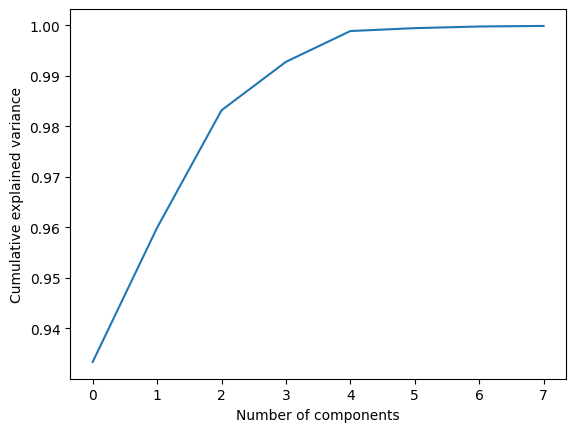

In [14]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [15]:
x_scaler = MinMaxScaler()

X_train = pd.DataFrame(x_scaler.fit_transform(X_train), 
                     columns=X_train.columns, 
                     index=X_train.index)

X_test = pd.DataFrame(x_scaler.fit_transform(X_test), 
                     columns=X_test.columns, 
                     index=X_test.index)

# X_train = x_scaler.fit_transform(X_train)

# X_test = x_scaler.fit_transform(X_test)

y_scaler = MinMaxScaler()

y_test = y_scaler.fit_transform(y_test)

y_train = y_scaler.fit_transform(y_train)

# **Model Training**

In [16]:
macro_test = pd.read_csv("/kaggle/input/macro-2025-2028/macro_pred_2025_2028.csv", index_col=0)
macro_test.index.name = "Date"
macro_test = macro_test.rename(columns={"Real Estate Activitie":"Egypt's Real Estate Activities (GDP) (Millions EGP)",
                          "Points":"Aqarmap Index"})

macro_test_lags = {}
for col in macro_test.columns:
    for i in range(1,21):
        lag = col + "_lag_" + str(i)
        macro_test_lags[lag] = macro_test[col].shift(i)
        
macro_test_lags_df = pd.concat(macro_test_lags, axis=1)

macro_test = pd.concat([macro_test, macro_test_lags_df], axis=1)
macro_test = macro_test.drop(columns=[col for col in macro_test.columns if col not in alex.columns], axis=1)

macro_test['Year'] = macro_test.index.str[:4].astype(int)
macro_test['Quarter'] = macro_test.index.str[5:].astype(int)

macro_test.fillna(0, inplace=True)
macro_test_pca = pca.fit_transform(macro_test.drop(["Year", "Quarter"], axis=1))

df_pca = pd.DataFrame(macro_test_pca, columns=[f'pca_{i+1}' for i in range(macro_test_pca.shape[1])])
macro_test_pca = pd.concat([macro_test[['Year', 'Quarter']].reset_index(drop=True), df_pca], axis=1)

macro_test_pca.replace(0, np.nan, inplace=True)

macro_test_pca = pd.DataFrame(x_scaler.fit_transform(macro_test_pca), 
                     columns=macro_test_pca.columns, 
                     index=macro_test_pca.index)

In [17]:
from sklearn.utils import resample
n_iterations = 20  # Number of bootstrapped models
predictions = []

for i in range(n_iterations):
    # Create a bootstrapped dataset
    X_resampled, y_resampled = resample(X_train, y_train)
    
    model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01,
                       reg_alpha=1,
                       reg_lambda=10)
    model.fit(X_resampled, y_resampled)
    
    y_pred = model.predict(macro_test_pca)
    y_pred = y_scaler.inverse_transform([y_pred])
    y_pred = ppm.iloc[-1] + np.cumsum(y_pred)
    predictions.append(y_pred)

# Convert predictions to a NumPy array
predictions = np.array(predictions)

# Calculate the mean and standard deviation of the predictions
mean_preds = np.mean(predictions, axis=0)
std_preds = np.std(predictions, axis=0)

# Confidence intervals
lower_bound = mean_preds - 1.96 * std_preds
upper_bound = mean_preds + 1.96 * std_preds

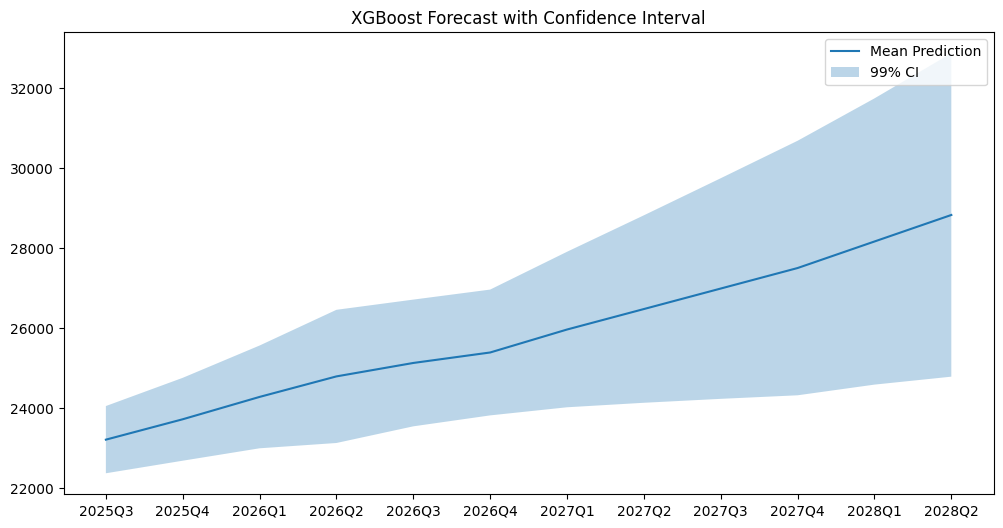

In [18]:
import matplotlib.pyplot as plt

mean_pred = predictions.mean(axis=0)

plt.figure(figsize=(12,6))
plt.plot(mean_pred, label="Mean Prediction")
plt.fill_between(macro_test.index[-len(lower_bound):], lower_bound, upper_bound, alpha=0.3, label='99% CI')
plt.legend()
plt.title("XGBoost Forecast with Confidence Interval")
plt.show()

In [21]:
dates = list(macro_test.index[-len(lower_bound):])
lower = list(lower_bound)
upper = list(upper_bound)
for i in range(len(lower)):
    print(dates[i] + " => (" + str(round(lower[i], 2)) + ", " + str(round(upper[i], 2)) + ") L.E.")

2025Q3 => (22372.62, 24053.57) L.E.
2025Q4 => (22687.04, 24759.22) L.E.
2026Q1 => (22997.17, 25566.71) L.E.
2026Q2 => (23129.83, 26459.85) L.E.
2026Q3 => (23546.39, 26715.0) L.E.
2026Q4 => (23819.94, 26965.5) L.E.
2027Q1 => (24022.7, 27910.9) L.E.
2027Q2 => (24135.26, 28822.48) L.E.
2027Q3 => (24233.59, 29749.61) L.E.
2027Q4 => (24322.36, 30686.29) L.E.
2028Q1 => (24589.35, 31745.7) L.E.
2028Q2 => (24787.95, 32873.5) L.E.
